In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import tensorflow as tf
import warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
tf.__version__

'2.16.1'

In [3]:
warnings.filterwarnings('ignore', category=UserWarning, message=r'.*PyDataset.*')

## Load Images And Labels

In [36]:
import os
from PIL import Image, UnidentifiedImageError

# Root directory of the images
root_dir = 'trafficsigns_dataset'  # Replace with the actual path

# Nested dictionary to store images categorized by two levels of labels
images_by_label = {}

# Function to traverse the dataset and load images and their labels
def load_images_and_labels(root_dir):
    # Iterate through each subdirectory in the root directory (first level)
    for sub_dir in os.listdir(root_dir):
        sub_dir_path = os.path.join(root_dir, sub_dir)
        
        # Check if the subdirectory is indeed a directory
        if os.path.isdir(sub_dir_path):
            # Initialize the first level label key
            images_by_label[sub_dir] = {}
            
            # Iterate again through the folders within the subdirectory (second level, specific labels)
            for label_dir in os.listdir(sub_dir_path):
                label_dir_path = os.path.join(sub_dir_path, label_dir)
                
                # Check if the second level is also a directory
                if os.path.isdir(label_dir_path):
                    # Initialize the second level label key
                    images_by_label[sub_dir][label_dir] = []
                    
                    # Iterate through all image files in the second level directory
                    for image_filename in os.listdir(label_dir_path):
                        # Ignore .DS_Store files
                        if image_filename == '.DS_Store':
                            continue
                        image_path = os.path.join(label_dir_path, image_filename)
                        try:
                            images_by_label[sub_dir][label_dir].append(image_path)
                        except UnidentifiedImageError:
                            # Print error message if the image cannot be identified
                            print(f"Cannot identify image file '{image_path}'")


# Load images and labels
load_images_and_labels(root_dir)

# Print the number of images for each category
for sub_dir, labels in images_by_label.items():
    for label, images in labels.items():
        print(f"{sub_dir}/{label}: {len(images)} images")
        
# Print the number of types for each shape
for shape, images in images_by_label.items():
    print(f"{shape}: {len(images)} type")
        
# Store unique shape names in label_names
label_names = list(images_by_label.keys())

# Now label_names contains all unique labels (shapes), sorted alphabetically
print(label_names)

diamond/rightofway: 282 images
hex/stop: 43 images
round/bicycle: 285 images
round/limitedtraffic: 125 images
round/noentry: 375 images
round/noparking: 242 images
round/roundabout: 98 images
round/speed: 316 images
round/trafficdirective: 195 images
round/traveldirection: 124 images
square/continue: 199 images
square/crossing: 95 images
square/laneend: 118 images
square/parking: 276 images
triangle/giveway: 231 images
triangle/warning: 695 images
diamond: 1 type
hex: 1 type
round: 8 type
square: 4 type
triangle: 2 type
['diamond', 'hex', 'round', 'square', 'triangle']


28no Unusual

In [5]:
def get_image_sizes(root_dir):
    sizes = []
    # Traverse through the directory structure in root_dir
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            # Check if the file is a PNG or JPG
            if file.lower().endswith('.png') or file.lower().endswith('.jpg'):
                try:
                    # Open the image file and append its size (width, height)
                    with Image.open(os.path.join(subdir, file)) as img:
                        sizes.append(img.size)
                except (IOError, UnidentifiedImageError):
                    # Continue to the next file if an error occurs
                    continue
    return sizes

# Call the function to get the sizes of all images in the directory
image_sizes = get_image_sizes(root_dir)

# Convert list of sizes to a NumPy array for statistical calculation
sizes_np = np.array(image_sizes)
min_size = sizes_np.min(axis=0)
max_size = sizes_np.max(axis=0)
mean_size = sizes_np.mean(axis=0)
std_dev_size = sizes_np.std(axis=0)
median_size = np.median(sizes_np, axis=0)

# Output the minimum, maximum, mean, standard deviation, and median sizes of the images
min_size, max_size, mean_size, std_dev_size, median_size


(array([28, 28]),
 array([28, 28]),
 array([28., 28.]),
 array([0., 0.]),
 array([28., 28.]))

In [6]:
train_data = {}
test_data = {}
validation_data = {}

for first_level, second_level_dict in images_by_label.items():
    print(first_level)
    train_data[first_level] = {}
    validation_data[first_level] = {}
    test_data[first_level] = {}
    
    for label, image_paths in second_level_dict.items():
        temp_images, test_images = train_test_split(image_paths, test_size=0.2, random_state=42)
        train_images, val_images = train_test_split(temp_images, test_size=0.2, random_state=42)
        
        # Save split data
        train_data[first_level][label] = train_images
        test_data[first_level][label] = test_images
        validation_data[first_level][label] = val_images


diamond
hex
round
square
triangle


## Genarate Datasets

In [13]:
train_data = {}
test_data = {}
validation_data = {}

for first_level, second_level_dict in images_by_label.items():
    train_data[first_level] = {}
    validation_data[first_level] = {}
    test_data[first_level] = {}
    
    for label, image_paths in second_level_dict.items():
        temp_images, test_images = train_test_split(image_paths, test_size=0.2, random_state=42)
        train_images, val_images = train_test_split(temp_images, test_size=0.2, random_state=42)
        
        # Save split data
        train_data[first_level][label] = train_images
        test_data[first_level][label] = test_images
        validation_data[first_level][label] = val_images


In [14]:
def create_dataframe_for_16_class(data_dict):
    rows = []
    for first_level, second_level_dict in data_dict.items():
        for label, image_paths in second_level_dict.items():
            for path in image_paths:
                # Extract the shape from the label
                shape = first_level
                rows.append({'ImagePath': path, 'Label': shape})
    return pd.DataFrame(rows)

def create_dataframe_for_5_class(data_dict):
    rows = []
    for first_level, second_level_dict in data_dict.items():
        for label, image_paths in second_level_dict.items():
            for path in image_paths:
                # Extract the shape from the label
                shape = first_level.split('_')[0]
                rows.append({'ImagePath': path, 'Label': shape})
    return pd.DataFrame(rows)

train_df = create_dataframe_for_16_class(train_data)
test_df = create_dataframe_for_16_class(test_data)
validation_df = create_dataframe_for_16_class(validation_data)


In [15]:
batch_size = 64

In [16]:
train_df

,ImagePath,Label
0,trafficsigns_dataset\diamond\rightofway\00123_...,diamond
1,trafficsigns_dataset\diamond\rightofway\00935_...,diamond
2,trafficsigns_dataset\diamond\rightofway\01003_...,diamond
3,trafficsigns_dataset\diamond\rightofway\01237_...,diamond
4,trafficsigns_dataset\diamond\rightofway\01873_...,diamond
...,...,...
2353,trafficsigns_dataset\triangle\warning\01339_00...,triangle
2354,trafficsigns_dataset\triangle\warning\01575_00...,triangle
2355,trafficsigns_dataset\triangle\warning\01114_00...,triangle
2356,trafficsigns_dataset\triangle\warning\00331_00...,triangle


In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize image data generators with rescaling
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Assuming train_df, validation_df, test_df, and batch_size are already defined
# Create a training data generator from a dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='ImagePath',          # Column in dataframe that contains the image paths
    y_col='Label',              # Column in dataframe that contains the labels
    color_mode='grayscale',     # Use grayscale images
    target_size=(28, 28),       # Resize images to 28x28 pixels
    batch_size=batch_size,      # Number of images to process in a batch
    class_mode='categorical',   # If it's a multi-class problem
    shuffle=True                # Shuffle the order of the images
)

# Create a validation data generator from a dataframe
val_generator = val_datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='ImagePath',          # Column in dataframe that contains the image paths
    y_col='Label',              # Column in dataframe that contains the labels
    color_mode='grayscale',     # Use grayscale images
    target_size=(28, 28),       # Resize images to 28x28 pixels
    batch_size=batch_size,      # Number of images to process in a batch
    class_mode='categorical',   # If it's a multi-class problem
    shuffle=False               # Do not shuffle the images
)

# Create a test data generator from a dataframe
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='ImagePath',          # Column in dataframe that contains the image paths
    y_col='Label',              # Column in dataframe that contains the labels
    color_mode='grayscale',     # Use grayscale images
    target_size=(28, 28),       # Resize images to 28x28 pixels
    batch_size=batch_size,      # Number of images to process in a batch
    class_mode='categorical',   # If it's a multi-class problem
    shuffle=False               # Do not shuffle the images
)


Found 2358 validated image filenames belonging to 5 classes.
Found 596 validated image filenames belonging to 5 classes.
Found 745 validated image filenames belonging to 5 classes.


## Transfer data to suit scikit-learn

In [18]:
import numpy as np

def get_data_from_generator(generator):
    batches = []
    labels = []
    # Iterate over the generator to collect data and labels
    for batch, label in generator:
        batches.append(batch)
        labels.append(label)
        if len(batches) >= len(generator):
            break  # Ensure not to iterate infinitely
    return np.vstack(batches), np.vstack(labels)

# Get training, validation, and test data and labels
X_train, y_train = get_data_from_generator(train_generator)
X_val, y_val = get_data_from_generator(val_generator)
X_test, y_test = get_data_from_generator(test_generator)


## Prepare function to draw Macro Average and F1 Score

In [19]:
class MacroF1Callback(tf.keras.callbacks.Callback):
    def __init__(self, val_data):
        super().__init__()
        self.val_data = val_data
        self.f1_scores = []
        
    def on_epoch_end(self, epoch, logs=None):
        val_pred = self.model.predict(self.val_data)
        val_pred = np.argmax(val_pred, axis=1)
        val_true = self.val_data.classes
        
        f1_scores_per_class = []
        for i in range(num_classes):
            f1 = tf.metrics.f1_score(val_true, val_pred, weights=tf.equal(val_true, i), name=f'f1_class_{i}')
            f1_scores_per_class.append(f1)
        
        macro_f1 = tf.metrics.mean(f1_scores_per_class)
        self.f1_scores.append(macro_f1[1])
        print(f"Epoch {epoch+1}: Macro Average F1 Score = {macro_f1[1]:.4f}")

## Decision Tree

In [22]:
# Assume the original shape of X_train and X_val is [number of samples, 28, 28, 1] - as extracted from an image generator

# Reshape X_train and X_val into two-dimensional arrays, one row per image
X_train = X_train.reshape(X_train.shape[0], -1)  # -1 calculates the necessary size based on the remaining dimensions
X_val = X_val.reshape(X_val.shape[0], -1)

# If using get_data_from_generator function to extract data, make sure to adjust the function or data before reshaping
# For example, ensure data is correctly extracted and transformed from the generator
X_train, y_train = get_data_from_generator(train_generator)
X_train = X_train.reshape(X_train.shape[0], -1)

X_val, y_val = get_data_from_generator(val_generator)
X_val = X_val.reshape(X_val.shape[0], -1)

# Train the decision tree model
tree_model = DecisionTreeClassifier(max_depth=10)
tree_model.fit(X_train, y_train)

# Evaluate the model on the validation set
y_pred_val = tree_model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))


Validation Accuracy: 0.8439597315436241


## Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the RandomForest model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Evaluate the model using the validation set
y_pred_val = rf_model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))


Validation Accuracy: 0.9060402684563759


## SVM

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Assuming y_train and y_val are one-hot encoded, with shape (number of samples, number of categories)
y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)

# Initialize and apply normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Initialize the SVM model
svm_model = SVC(kernel='rbf', C=1.0, gamma='auto', max_iter=1000)

# Train the SVM model
svm_model.fit(X_train_scaled, y_train)

# Evaluate the SVM model on the validation set
y_pred_val = svm_model.predict(X_val_scaled)
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))

C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Validation Accuracy: 0.9546979865771812


## MLP Baseline Model for Multi-class Task


### Adjust the Model Compilation

In [28]:
num_classes = 5
input_shape = (28, 28)
baseline_categorical = tf.keras.models.Sequential([
    tf.keras.Input(shape=input_shape),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [29]:
baseline_categorical.compile(loss='categorical_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=[
        'accuracy',
        tf.keras.metrics.F1Score(average='macro', name='f1_score_macro'), #Get F1 Score by tensorflow API
        tf.keras.metrics.F1Score(average='micro', name='f1_score_micro'),
        tf.keras.metrics.F1Score(average='weighted', name='f1_score_weighted')
    ])

### Training the Model

In [30]:
epochs = 50
macro_f1_callback = MacroF1Callback(val_generator)
history_baseline_categorical = baseline_categorical.fit(
    train_generator, 
    validation_data=val_generator,
    epochs=epochs,

)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.5778 - f1_score_macro: 0.3324 - f1_score_micro: 0.5778 - f1_score_weighted: 0.5364 - loss: 1.1615 - val_accuracy: 0.8221 - val_f1_score_macro: 0.6215 - val_f1_score_micro: 0.8221 - val_f1_score_weighted: 0.8066 - val_loss: 0.5910
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.8480 - f1_score_macro: 0.6623 - f1_score_micro: 0.8480 - f1_score_weighted: 0.8383 - loss: 0.5379 - val_accuracy: 0.8523 - val_f1_score_macro: 0.6504 - val_f1_score_micro: 0.8523 - val_f1_score_weighted: 0.8415 - val_loss: 0.4687
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.8939 - f1_score_macro: 0.7261 - f1_score_micro: 0.8939 - f1_score_weighted: 0.8884 - loss: 0.4015 - val_accuracy: 0.9027 - val_f1_score_macro: 0.7911 - val_f1_score_micro: 0.9027 - val_f1_score_weighted: 0.8988 - val_loss: 0.3731
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9299 - f1_score_macro: 0.7966 - f1_score_micro: 0.

Epoch 26/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9975 - f1_score_macro: 0.9923 - f1_score_micro: 0.9975 - f1_score_weighted: 0.9975 - loss: 0.0184 - val_accuracy: 0.9681 - val_f1_score_macro: 0.9321 - val_f1_score_micro: 0.9681 - val_f1_score_weighted: 0.9678 - val_loss: 0.1116
Epoch 27/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9984 - f1_score_macro: 0.9827 - f1_score_micro: 0.9984 - f1_score_weighted: 0.9984 - loss: 0.0178 - val_accuracy: 0.9664 - val_f1_score_macro: 0.9303 - val_f1_score_micro: 0.9664 - val_f1_score_weighted: 0.9661 - val_loss: 0.1189
Epoch 28/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9995 - f1_score_macro: 0.9939 - f1_score_micro: 0.9995 - f1_score_weighted: 0.9995 - loss: 0.0144 - val_accuracy: 0.9648 - val_f1_score_macro: 0.9367 - val_f1_score_micro: 0.9648 - val_f1_score_weighted: 0.9645 - val_loss: 0.1149
Epoch 29/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9996 - f1_score_macro: 0.9942 - f1_score_micro

### Plotting and Evaluating

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9518 - f1_score_macro: 0.6854 - f1_score_micro: 0.9518 - f1_score_weighted: 0.9562 - loss: 0.1610
  Accuracy Type  Accuracy
0      Training  1.000000
1    Validation  0.969799
2       Testing  0.958389


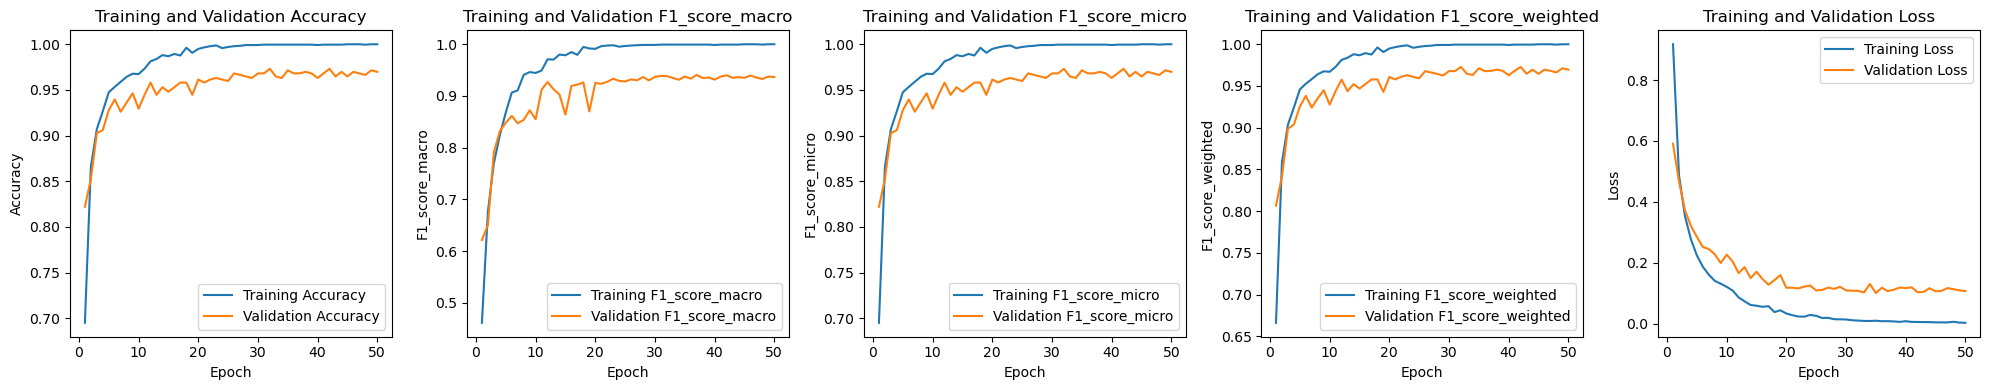

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have test_generator or similar test data
test_loss, test_accuracy, _, _, _ = baseline_categorical.evaluate(test_generator)

# Get training and validation accuracy from the history object
train_accuracy = history_baseline_categorical.history['accuracy'][-1]
val_accuracy = history_baseline_categorical.history['val_accuracy'][-1]

# Create data dictionary
data = {
    'Accuracy Type': ['Training', 'Validation', 'Testing'],
    'Accuracy': [train_accuracy, val_accuracy, test_accuracy]
}

# Create DataFrame
df = pd.DataFrame(data)

# Display DataFrame
print(df)

def plot_training_history(history):
    """
    Plot training and validation metrics based on the History object from a Keras model.

    Parameters:
    - history: History object returned from the fit method.
    """
    epochs_range = range(1, len(history.history['accuracy']) + 1)  # Assuming there's at least the 'accuracy' metric
    metrics = [key for key in history.history.keys() if not key.startswith("val_")]  # Retrieve all non-validation metrics
    _, axes = plt.subplots(1, len(metrics), figsize=(20, 4))  # Dynamically adjust the number of subplots based on the number of metrics

    for idx, metric in enumerate(metrics):
        # Plot the training and validation curve for each metric in each subplot
        axes[idx].plot(epochs_range, history.history[metric], label=f'Training {metric.capitalize()}')
        axes[idx].plot(epochs_range, history.history[f"val_{metric}"], label=f'Validation {metric.capitalize()}')
        axes[idx].legend()
        axes[idx].set_title(f'Training and Validation {metric.capitalize()}')
        axes[idx].set_xlabel('Epoch')
        axes[idx].set_ylabel(metric.capitalize())
    
    plt.tight_layout()
    plt.show()

# Assuming history_baseline_categorical is the training history object of your MLP model
# Call the function to plot
plot_training_history(history_baseline_categorical)


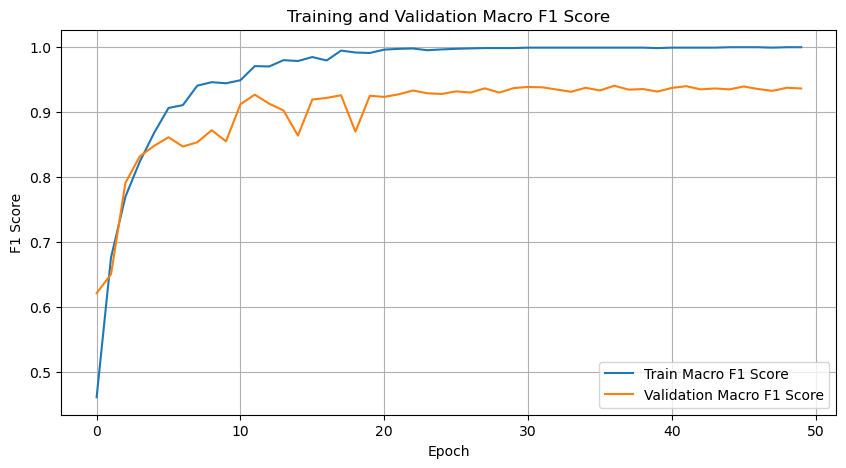

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history_baseline_categorical.history['f1_score_macro'], label='Train Macro F1 Score')
plt.plot(history_baseline_categorical.history['val_f1_score_macro'], label='Validation Macro F1 Score')
plt.title('Training and Validation Macro F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()


## Modify images to make classification more difficult

In [33]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  # Rotation range (degrees), adjustable range, e.g., 20-40
    width_shift_range=0.1,  # Horizontal shift range
    height_shift_range=0.1,  # Vertical shift range
    shear_range=0.1,  # Shearing range
    zoom_range=0.1,  # Zoom range
    horizontal_flip=True,  # Horizontal flip
)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='ImagePath',
    y_col='Label',
    color_mode='grayscale',
    target_size=(28, 28),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='ImagePath',
    y_col='Label',
    color_mode='grayscale',
    target_size=(28, 28),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='ImagePath',
    y_col='Label',
    color_mode='grayscale',
    target_size=(28, 28),
    batch_size=batch_size,
    class_mode='categorical',  
    shuffle=False
)


Found 2358 validated image filenames belonging to 5 classes.
Found 596 validated image filenames belonging to 5 classes.
Found 745 validated image filenames belonging to 5 classes.


## SVM Model with modified dataset

In [37]:
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

def get_data_from_generator(generator):
    batches = []
    labels = []
    # Iterate over the generator to collect data and labels
    for batch, label in generator:
        batches.append(batch)
        labels.append(label)
        if len(batches) >= len(generator):
            break  # Ensure there is no infinite iteration
    return np.vstack(batches), np.vstack(labels)

X_train, y_train = get_data_from_generator(train_generator)
X_val, y_val = get_data_from_generator(val_generator)
X_test, y_test = get_data_from_generator(test_generator)

# Reshape the data to fit the input requirements of StandardScaler
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Assuming y_train and y_val are one-hot encoded, with shape (number of samples, number of classes)
y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)

# Initialize and apply standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Initialize SVM model
svm_model = SVC(kernel='rbf', C=1.0, gamma='auto', max_iter=1000)

# Train the SVM model
svm_model.fit(X_train_scaled, y_train)

# Evaluate the SVM model on the validation set
y_pred_val = svm_model.predict(X_val_scaled)
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

report = classification_report(y_val, y_pred_val, target_names=label_names, zero_division=1, output_dict=True)
print(classification_report(y_val, y_pred_val, target_names=label_names, zero_division=1))


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Validation Accuracy: 0.785234899328859
              precision    recall  f1-score   support

     diamond       0.88      0.47      0.61        45
         hex       1.00      0.00      0.00         7
       round       0.73      0.95      0.83       284
      square       0.84      0.52      0.64       111
    triangle       0.88      0.80      0.84       149

    accuracy                           0.79       596
   macro avg       0.87      0.55      0.58       596
weighted avg       0.80      0.79      0.77       596



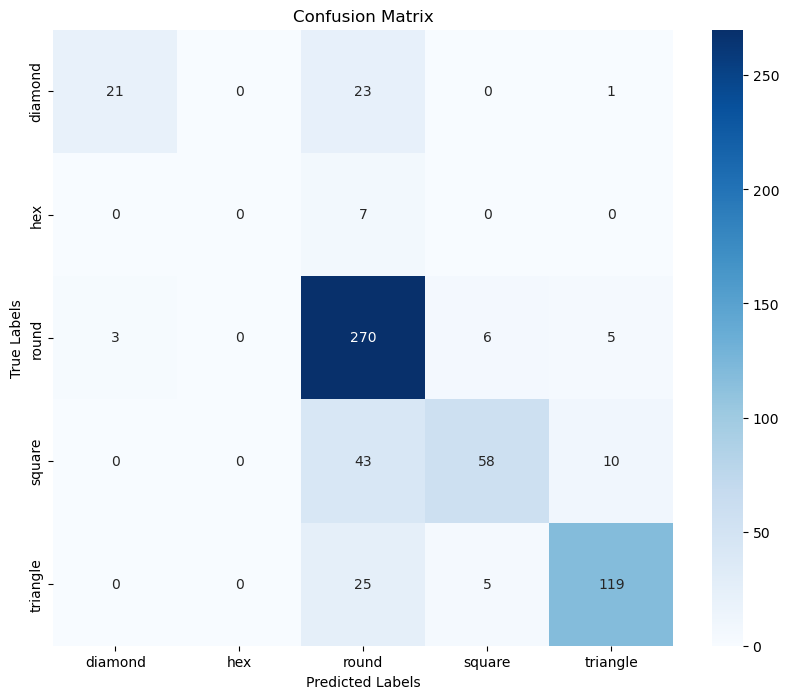

In [42]:
cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [38]:
label_names

['diamond', 'hex', 'round', 'square', 'triangle']

## MLP Model with modified dataset

### Adjust the Model Compilation

In [39]:
num_classes = 5
input_shape = (28, 28)
baseline_categorical = tf.keras.models.Sequential([
    tf.keras.Input(shape=input_shape),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [40]:
baseline_categorical.compile(loss='binary_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=[
        'accuracy',
        tf.keras.metrics.F1Score(average='macro', name='f1_score_macro'),
        tf.keras.metrics.F1Score(average='micro', name='f1_score_micro'),
        tf.keras.metrics.F1Score(average='weighted', name='f1_score_weighted')
    ])

### Training the Model

In [41]:
epochs = 50
history_baseline_categorical = baseline_categorical.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.4636 - f1_score_macro: 0.2038 - f1_score_micro: 0.4636 - f1_score_weighted: 0.3857 - loss: 0.4658 - val_accuracy: 0.5671 - val_f1_score_macro: 0.2724 - val_f1_score_micro: 0.5671 - val_f1_score_weighted: 0.4793 - val_loss: 0.3767
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.5146 - f1_score_macro: 0.2531 - f1_score_micro: 0.5146 - f1_score_weighted: 0.4484 - loss: 0.3950 - val_accuracy: 0.6426 - val_f1_score_macro: 0.3497 - val_f1_score_micro: 0.6426 - val_f1_score_weighted: 0.5818 - val_loss: 0.3364
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.5596 - f1_score_macro: 0.3067 - f1_score_micro: 0.5596 - f1_score_weighted: 0.4955 - loss: 0.3793 - val_accuracy: 0.6829 - val_f1_score_macro: 0.4764 - val_f1_score_micro: 0.6829 - val_f1_score_weighted: 0.6595 - val_loss: 0.3315
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.6020 - f1_score_macro: 0.3598 - f1_score_micro: 

Epoch 26/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.7541 - f1_score_macro: 0.5775 - f1_score_micro: 0.7541 - f1_score_weighted: 0.7450 - loss: 0.2474 - val_accuracy: 0.8523 - val_f1_score_macro: 0.6491 - val_f1_score_micro: 0.8523 - val_f1_score_weighted: 0.8448 - val_loss: 0.1887
Epoch 27/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.7438 - f1_score_macro: 0.5364 - f1_score_micro: 0.7438 - f1_score_weighted: 0.7298 - loss: 0.2546 - val_accuracy: 0.8574 - val_f1_score_macro: 0.6531 - val_f1_score_micro: 0.8574 - val_f1_score_weighted: 0.8510 - val_loss: 0.1792
Epoch 28/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.7450 - f1_score_macro: 0.5567 - f1_score_micro: 0.7450 - f1_score_weighted: 0.7311 - loss: 0.2480 - val_accuracy: 0.8389 - val_f1_score_macro: 0.6474 - val_f1_score_micro: 0.8389 - val_f1_score_weighted: 0.8350 - val_loss: 0.1991
Epoch 29/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.7609 - f1_score_macro: 0.5555 - f1_score_mic

### Plotting and Evaluating

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8600 - f1_score_macro: 0.4811 - f1_score_micro: 0.8600 - f1_score_weighted: 0.8577 - loss: 0.1593
  Accuracy Type  Accuracy
0      Training  0.811705
1    Validation  0.885906
2       Testing  0.868456


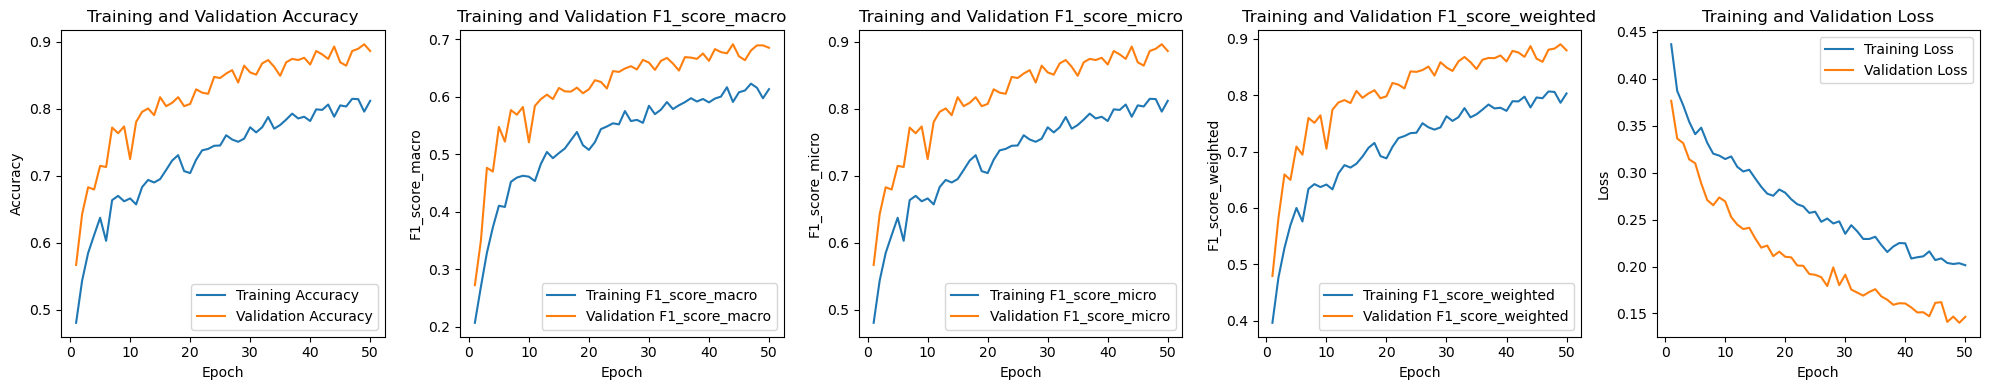

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Evaluate the model on the test data
test_loss, test_accuracy, _, _, _ = baseline_categorical.evaluate(test_generator)

# Get training and validation accuracy from the history object
train_accuracy = history_baseline_categorical.history['accuracy'][-1]
val_accuracy = history_baseline_categorical.history['val_accuracy'][-1]

# Create data dictionary
data = {
    'Accuracy Type': ['Training', 'Validation', 'Testing'],
    'Accuracy': [train_accuracy, val_accuracy, test_accuracy]
}

# Create DataFrame
df = pd.DataFrame(data)

# Display DataFrame
print(df)

def plot_training_history(history):
    """
    Plot training and validation metrics based on the History object from a Keras model.

    Parameters:
    - history: History object returned from the fit method.
    """
    epochs_range = range(1, len(history.history['accuracy']) + 1)  # Assuming there's at least the 'accuracy' metric
    metrics = [key for key in history.history.keys() if not key.startswith("val_")]  # Retrieve all non-validation metrics
    _, axes = plt.subplots(1, len(metrics), figsize=(20, 4))  # Dynamically adjust the number of subplots based on the number of metrics

    for idx, metric in enumerate(metrics):
        # Plot the training and validation curve for each metric in each subplot
        axes[idx].plot(epochs_range, history.history[metric], label=f'Training {metric.capitalize()}')
        axes[idx].plot(epochs_range, history.history[f"val_{metric}"], label=f'Validation {metric.capitalize()}')
        axes[idx].legend()
        axes[idx].set_title(f'Training and Validation {metric.capitalize()}')
        axes[idx].set_xlabel('Epoch')
        axes[idx].set_ylabel(metric.capitalize())
    
    plt.tight_layout()
    plt.show()

# Assuming history_baseline_categorical is the training history object of your MLP model
# Call the function to plot
plot_training_history(history_baseline_categorical)


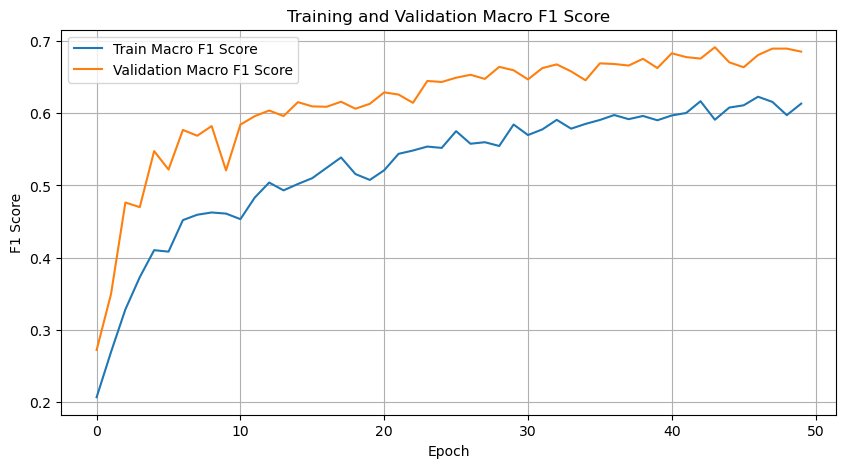

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history_baseline_categorical.history['f1_score_macro'], label='Train Macro F1 Score')
plt.plot(history_baseline_categorical.history['val_f1_score_macro'], label='Validation Macro F1 Score')
plt.title('Training and Validation Macro F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()


## CNN Model for Multi Class

### Create CNN

In [60]:
import tensorflow as tf
from tensorflow.keras import layers, models

num_classes = 5

cnn_model = models.Sequential([
    layers.Input(shape=(28, 28, 1)),  
    layers.Conv2D(32, (3, 3), activation='relu'),  
    layers.MaxPooling2D((2, 2)),  
    layers.Conv2D(64, (3, 3), activation='relu'),  
    layers.MaxPooling2D((2, 2)),  
    layers.Conv2D(128, (3, 3), activation='relu'),  
    layers.MaxPooling2D((2, 2)),  
    layers.Flatten(),  
    layers.Dense(512, activation='relu'),  
    layers.Dense(num_classes, activation='softmax')  
])

cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[
        'accuracy',
        tf.keras.metrics.F1Score(average='macro', name='f1_score_macro'),
        tf.keras.metrics.F1Score(average='micro', name='f1_score_micro'),
        tf.keras.metrics.F1Score(average='weighted', name='f1_score_weighted')
    ])


### Per-Class Macro F1 Score Callback

In [61]:
from tensorflow.keras.callbacks import Callback
import numpy as np

class PerClassF1Score(Callback):
    def __init__(self, validation_generator, num_classes):
        super().__init__()
        self.validation_generator = validation_generator
        self.num_classes = num_classes
        self.f1_scores_per_class = []

    def on_epoch_end(self, epoch, logs=None):
        val_preds = self.model.predict(self.validation_generator)
        val_classes = np.argmax(val_preds, axis=1)
        true_classes = self.validation_generator.classes
        # Initialize confusion matrix components
        TP = np.zeros(self.num_classes)
        FP = np.zeros(self.num_classes)
        FN = np.zeros(self.num_classes)
        
        for true, pred in zip(true_classes, val_classes):
            if true == pred:
                TP[true] += 1
            else:
                FP[pred] += 1
                FN[true] += 1

        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1_score = 2 * (precision * recall) / (precision + recall)
        self.f1_scores_per_class.append(f1_score)  # Save per-class F1 scores for this epoch


In [62]:
validation_data = val_generator  # Assume val_generator is already defined
per_class_f1_score_callback = PerClassF1Score(validation_data, num_classes)

epochs = 50
history_cnn = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[per_class_f1_score_callback],
    verbose=1
)


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.4320 - f1_score_macro: 0.1408 - f1_score_micro: 0.4320 - f1_score_weighted: 0.3025 - loss: 
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.4340 - f1_score_macro: 0.1408 - f1_score_micro: 0.4340 - f1_score_weighted: 0.3033 - loss: 1.3834 - val_accuracy: 0.4765 - val_f1_score_macro: 0.1291 - val_f1_score_micro: 0.4765 - val_f1_score_weighted: 0.3076 - val_loss: 1.2487
Epoch 2/50


C:\Users\HP\AppData\Local\Temp\ipykernel_5772\367617216.py:27: RuntimeWarning: invalid value encountered in divide
  precision = TP / (TP + FP)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.4858 - f1_score_macro: 0.1552 - f1_score_micro: 0.4858 - f1_score_weighted: 0.3359 - loss:
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.4875 - f1_score_macro: 0.1585 - f1_score_micro: 0.4875 - f1_score_weighted: 0.3399 - loss: 1.2338 - val_accuracy: 0.6728 - val_f1_score_macro: 0.4297 - val_f1_score_micro: 0.6728 - val_f1_score_weighted: 0.6451 - val_loss: 1.0672
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6240 - f1_score_macro: 0.3591 - f1_score_micro: 0.6240 - f1_score_weighted: 0.5867 - loss: 1
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.6250 - f1_score_macro: 0.3601 - f1_score_micro: 0.6250 - f1_score_weighted: 0.5877 - loss: 1.0093 - val_accuracy: 0.7416 - val_f1_score_macro: 0.4654 - val_f1_score_micro: 0.7416 - val_f1_score_weighted: 0.7075 - val_loss: 0.7344
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7112 - f1_score_macro: 0.4835 - f1_score_micro: 0.7112 - f1_sc

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9453 - f1_score_macro: 0.8482 - f1_score_micro: 0.9453 - f1_score_weighted: 0.9441 - loss: 0
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.9453 - f1_score_macro: 0.8494 - f1_score_micro: 0.9453 - f1_score_weighted: 0.9442 - loss: 0.1706 - val_accuracy: 0.9732 - val_f1_score_macro: 0.9436 - val_f1_score_micro: 0.9732 - val_f1_score_weighted: 0.9729 - val_loss: 0.0829
Epoch 19/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step  - accuracy: 0.9538 - f1_score_macro: 0.8939 - f1_score_micro: 0.9538 - f1_score_weighted: 0.9526 - lo
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.9538 - f1_score_macro: 0.8930 - f1_score_micro: 0.9538 - f1_score_weighted: 0.9525 - loss: 0.1483 - val_accuracy: 0.9832 - val_f1_score_macro: 0.9543 - val_f1_score_micro: 0.9832 - val_f1_score_weighted: 0.9830 - val_loss: 0.0698
Epoch 20/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9472 - f1_score_macro: 0.9085 - f1_score_micro: 0.9472 - f1_sc

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9778 - f1_score_macro: 0.9671 - f1_score_micro: 0.9778 - f1_score_weighted: 0.9777 - loss: 
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.9777 - f1_score_macro: 0.9669 - f1_score_micro: 0.9777 - f1_score_weighted: 0.9776 - loss: 0.0707 - val_accuracy: 0.9899 - val_f1_score_macro: 0.9923 - val_f1_score_micro: 0.9899 - val_f1_score_weighted: 0.9900 - val_loss: 0.0447
Epoch 35/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9790 - f1_score_macro: 0.9573 - f1_score_micro: 0.9790 - f1_score_weighted: 0.9789 - los
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.9788 - f1_score_macro: 0.9570 - f1_score_micro: 0.9788 - f1_score_weighted: 0.9787 - loss: 0.0679 - val_accuracy: 0.9916 - val_f1_score_macro: 0.9810 - val_f1_score_micro: 0.9916 - val_f1_score_weighted: 0.9917 - val_loss: 0.0361
Epoch 36/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9773 - f1_score_macro: 0.9566 - f1_score_micro: 0.9773 - f1_sco

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9757 - f1_score_macro: 0.9581 - f1_score_micro: 0.9757 - f1_score_weighted: 0.9758 - loss: 0
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.9759 - f1_score_macro: 0.9583 - f1_score_micro: 0.9759 - f1_score_weighted: 0.9760 - loss: 0.0580 - val_accuracy: 0.9782 - val_f1_score_macro: 0.9707 - val_f1_score_micro: 0.9782 - val_f1_score_weighted: 0.9782 - val_loss: 0.0483


### Plotting and Evaluating

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9830 - f1_score_macro: 0.7513 - f1_score_micro: 0.9830 - f1_score_weighted: 0.9848 - loss: 0.0547
  Accuracy Type  Accuracy
0      Training  0.983036
1    Validation  0.978188
2       Testing  0.982550


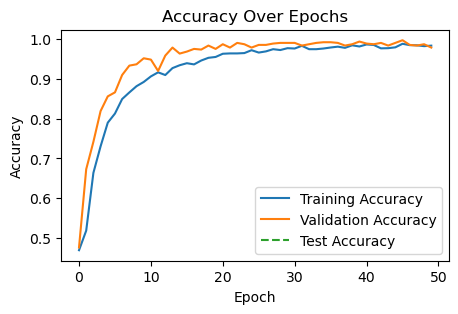

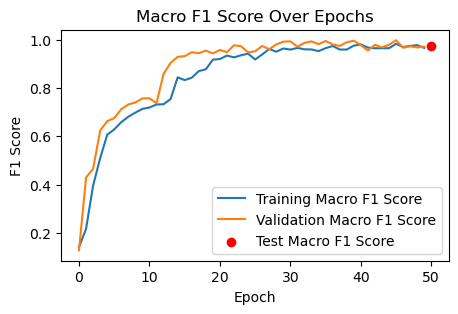

In [63]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

# Evaluate on the test set
test_loss, test_accuracy, test_f1_macro, _, _ = cnn_model.evaluate(test_generator)

# Gather accuracy data
train_accuracy = history_cnn.history['accuracy'][-1]
val_accuracy = history_cnn.history['val_accuracy'][-1]

# Create data dictionary
data = {
    'Accuracy Type': ['Training', 'Validation', 'Testing'],
    'Accuracy': [train_accuracy, val_accuracy, test_accuracy]
}

# Create DataFrame
df = pd.DataFrame(data)
print(df)

# Plot the training, validation, and testing accuracy
plt.figure(figsize=(5, 3))
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.plot([None]*(epochs-1) + [test_accuracy], label='Test Accuracy', linestyle='--')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot macro F1 score
plt.figure(figsize=(5, 3))
plt.plot(history_cnn.history['f1_score_macro'], label='Training Macro F1 Score')
if 'val_f1_score_macro' in history_cnn.history:
    plt.plot(history_cnn.history['val_f1_score_macro'], label='Validation Macro F1 Score')
plt.scatter(epochs, test_f1_macro, color='red', label='Test Macro F1 Score')
plt.title('Macro F1 Score Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.show()


###  Extract and Plot Data

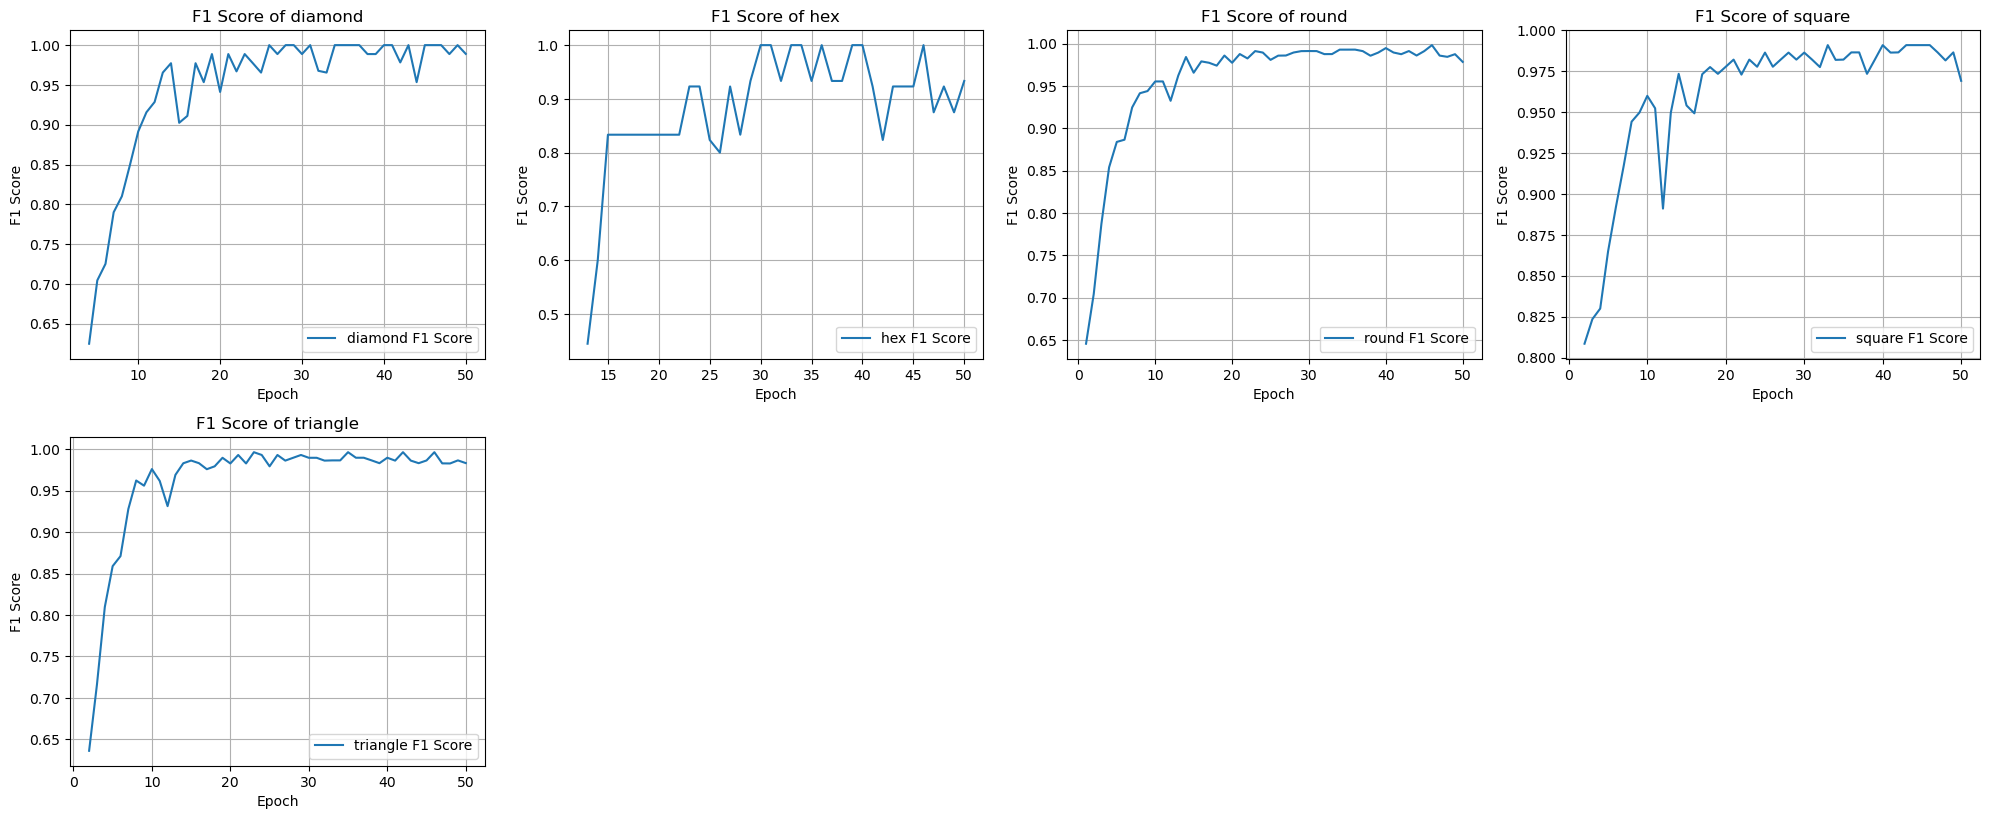

<Figure size 640x480 with 0 Axes>

In [64]:
import matplotlib.pyplot as plt

def plot_per_class_f1_scores(callback, label_names):
    """
    Plot the per-class F1 scores over the epochs in a 4x4 grid, each subplot representing one class.

    Parameters:
    - callback: Instance of PerClassF1Score that has been used during model training.
    - label_names: List of label names corresponding to each class.
    """
    epochs = len(callback.f1_scores_per_class)
    num_classes = len(label_names)
    f1_scores = np.array(callback.f1_scores_per_class)  # Shape will be [epochs, num_classes]

    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 16))
    axes = axes.flatten()

    for i in range(num_classes):
        ax = axes[i]
        ax.plot(range(1, epochs + 1), f1_scores[:, i], label=f'{label_names[i]} F1 Score')
        ax.set_title(f'F1 Score of {label_names[i]}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('F1 Score')
        ax.legend(loc='lower right')
        ax.grid(True)
    # Hide any unused subplots
    for i in range(num_classes, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

    plt.tight_layout()
    plt.show()

# Example of how to call this function
plot_per_class_f1_scores(per_class_f1_score_callback, label_names)


### Update CNN

In [51]:
from tensorflow.keras import models, layers

num_classes = 5  # Adjust the number of classes according to your task

cnn_model = models.Sequential([
    layers.Input(shape=(28, 28, 1)),  # Input for grayscale images, 1 channel
    layers.Conv2D(32, (3, 3), padding='same'),  # First convolutional layer, 32 filters
    layers.BatchNormalization(),  # Adding batch normalization
    layers.Activation('relu'),  # Activation layer
    layers.MaxPooling2D((2, 2)),  # Max pooling
    layers.Conv2D(64, (3, 3), padding='same'),  # Second convolutional layer, 64 filters
    layers.BatchNormalization(),  # Adding batch normalization
    layers.Activation('relu'),  # Activation layer
    layers.MaxPooling2D((2, 2)),  # Max pooling
    layers.Conv2D(128, (3, 3), padding='same'),  # Third convolutional layer, 128 filters
    layers.BatchNormalization(),  # Adding batch normalization
    layers.Activation('relu'),  # Activation layer
    layers.MaxPooling2D((2, 2)),  # Max pooling
    layers.Flatten(),  # Flatten the convolutional result
    layers.Dense(512),  # Fully connected layer
    layers.BatchNormalization(),  # Adding batch normalization
    layers.Activation('relu'),  # Activation layer
    layers.Dense(num_classes, activation='softmax')  # Output layer, using softmax activation
])

# Usage
num_classes = 5
validation_data = val_generator  # Assume val_generator is already defined
per_class_accuracy_callback = PerClassF1Score(validation_data, num_classes)

cnn_model.compile(
    loss='categorical_crossentropy',  # Using categorical crossentropy loss
    optimizer=tf.keras.optimizers.Adam(),  # Adam optimizer
    metrics=[
        'accuracy',
        tf.keras.metrics.F1Score(average='macro', name='f1_score_macro'),
        tf.keras.metrics.F1Score(average='micro', name='f1_score_micro'),
        tf.keras.metrics.F1Score(average='weighted', name='f1_score_weighted')
    ])


### Per class accuracy callback

In [52]:
from tensorflow.keras.callbacks import Callback
import numpy as np

class PerClassF1Score(Callback):
    def __init__(self, validation_generator, num_classes):
        super().__init__()
        self.validation_generator = validation_generator
        self.num_classes = num_classes
        self.f1_scores_per_class = []

    def on_epoch_end(self, epoch, logs=None):
        val_preds = self.model.predict(self.validation_generator)
        val_classes = np.argmax(val_preds, axis=1)
        true_classes = self.validation_generator.classes
        # Initialize confusion matrix components
        TP = np.zeros(self.num_classes)
        FP = np.zeros(self.num_classes)
        FN = np.zeros(self.num_classes)
        
        for true, pred in zip(true_classes, val_classes):
            if true == pred:
                TP[true] += 1
            else:
                FP[pred] += 1
                FN[true] += 1

        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1_score = 2 * (precision * recall) / (precision + recall)
        self.f1_scores_per_class.append(f1_score)  # Save per-class F1 scores for this epoch


### Training the Model

In [53]:
validation_data = val_generator  # Assume val_generator is already defined
per_class_accuracy_callback = PerClassF1Score(validation_data, num_classes)

epochs = 50
history_cnn = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[per_class_accuracy_callback],
    verbose=1
)


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step  - accuracy: 0.6043 - f1_score_macro: 0.4570 - f1_score_micro: 0.6043 - f1_score_weighted: 0.6137 - loss:
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 166ms/step - accuracy: 0.6081 - f1_score_macro: 0.4602 - f1_score_micro: 0.6081 - f1_score_weighted: 0.6173 - loss: 1.1178 - val_accuracy: 0.4765 - val_f1_score_macro: 0.1291 - val_f1_score_micro: 0.4765 - val_f1_score_weighted: 0.3076 - val_loss: 1.2666
Epoch 2/50


C:\Users\HP\AppData\Local\Temp\ipykernel_5772\367617216.py:27: RuntimeWarning: invalid value encountered in divide
  precision = TP / (TP + FP)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/stepp - accuracy: 0.8959 - f1_score_macro: 0.7623 - f1_score_micro: 0.8959 - f1_score_weighted: 0.8922 - loss: 0
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.8962 - f1_score_macro: 0.7632 - f1_score_micro: 0.8962 - f1_score_weighted: 0.8924 - loss: 0.2997 - val_accuracy: 0.4765 - val_f1_score_macro: 0.1291 - val_f1_score_micro: 0.4765 - val_f1_score_weighted: 0.3076 - val_loss: 1.4802
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step  - accuracy: 0.9298 - f1_score_macro: 0.8604 - f1_score_micro: 0.9298 - f1_score_weighted: 0.9295 - loss: 
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.9299 - f1_score_macro: 0.8604 - f1_score_micro: 0.9299 - f1_score_weighted: 0.9295 - loss: 0.2016 - val_accuracy: 0.4765 - val_f1_score_macro: 0.1291 - val_f1_score_micro: 0.4765 - val_f1_score_weighted: 0.3076 - val_loss: 1.6504
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step  - accuracy: 0.9382 - f1_score_macro: 0.8234 - f1_score_micro: 0.9382 - f

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step  - accuracy: 0.9828 - f1_score_macro: 0.9533 - f1_score_micro: 0.9828 - f1_score_weighted: 0.9822 - los
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step - accuracy: 0.9829 - f1_score_macro: 0.9539 - f1_score_micro: 0.9829 - f1_score_weighted: 0.9824 - loss: 0.0491 - val_accuracy: 0.9933 - val_f1_score_macro: 0.9953 - val_f1_score_micro: 0.9933 - val_f1_score_weighted: 0.9933 - val_loss: 0.0242
Epoch 19/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/stepp - accuracy: 0.9917 - f1_score_macro: 0.9816 - f1_score_micro: 0.9917 - f1_score_weighted: 0.9917 - los
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 190ms/step - accuracy: 0.9916 - f1_score_macro: 0.9818 - f1_score_micro: 0.9916 - f1_score_weighted: 0.9916 - loss: 0.0322 - val_accuracy: 0.9849 - val_f1_score_macro: 0.9813 - val_f1_score_micro: 0.9849 - val_f1_score_weighted: 0.9851 - val_loss: 0.0469
Epoch 20/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/stepp - accuracy: 0.9912 - f1_score_macro: 0.9851 - f1_score_micro: 0.9912 - f1_sco

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step  - accuracy: 0.9863 - f1_score_macro: 0.9864 - f1_score_micro: 0.9863 - f1_score_weighted: 0.9864 - lo
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - accuracy: 0.9864 - f1_score_macro: 0.9865 - f1_score_micro: 0.9864 - f1_score_weighted: 0.9865 - loss: 0.0325 - val_accuracy: 0.9899 - val_f1_score_macro: 0.9901 - val_f1_score_micro: 0.9899 - val_f1_score_weighted: 0.9899 - val_loss: 0.0240
Epoch 35/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step  - accuracy: 0.9925 - f1_score_macro: 0.9846 - f1_score_micro: 0.9925 - f1_score_weighted: 0.9925 - los
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 181ms/step - accuracy: 0.9925 - f1_score_macro: 0.9847 - f1_score_micro: 0.9925 - f1_score_weighted: 0.9925 - loss: 0.0272 - val_accuracy: 0.9916 - val_f1_score_macro: 0.9787 - val_f1_score_micro: 0.9916 - val_f1_score_weighted: 0.9916 - val_loss: 0.0285
Epoch 36/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/stepp - accuracy: 0.9918 - f1_score_macro: 0.9821 - f1_score_micro: 0.9918 - f1_scor

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step  - accuracy: 0.9924 - f1_score_macro: 0.9890 - f1_score_micro: 0.9924 - f1_score_weighted: 0.9924 - los
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 214ms/step - accuracy: 0.9924 - f1_score_macro: 0.9891 - f1_score_micro: 0.9924 - f1_score_weighted: 0.9924 - loss: 0.0165 - val_accuracy: 0.9950 - val_f1_score_macro: 0.9943 - val_f1_score_micro: 0.9950 - val_f1_score_weighted: 0.9950 - val_loss: 0.0183


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9914 - f1_score_macro: 0.7640 - f1_score_micro: 0.9914 - f1_score_weighted: 0.9928 - loss: 0.0153
  Accuracy Type  Accuracy
0      Training  0.993639
1    Validation  0.994966
2       Testing  0.995973


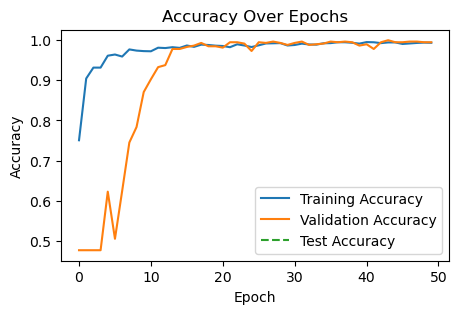

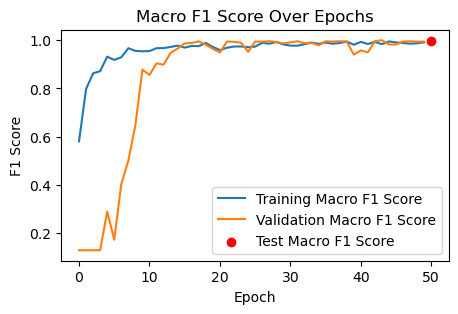

In [54]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

# Evaluate on the test set
test_loss, test_accuracy, test_f1_macro, _, _ = cnn_model.evaluate(test_generator)

# Gather accuracy data
train_accuracy = history_cnn.history['accuracy'][-1]
val_accuracy = history_cnn.history['val_accuracy'][-1]

# Create data dictionary
data = {
    'Accuracy Type': ['Training', 'Validation', 'Testing'],
    'Accuracy': [train_accuracy, val_accuracy, test_accuracy]
}

# Create DataFrame
df = pd.DataFrame(data)
print(df)

# Plot the training, validation, and testing accuracy
plt.figure(figsize=(5, 3))
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.plot([None]*(epochs-1) + [test_accuracy], label='Test Accuracy', linestyle='--')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot macro F1 score
plt.figure(figsize=(5, 3))
plt.plot(history_cnn.history['f1_score_macro'], label='Training Macro F1 Score')
if 'val_f1_score_macro' in history_cnn.history:
    plt.plot(history_cnn.history['val_f1_score_macro'], label='Validation Macro F1 Score')
plt.scatter(epochs, test_f1_macro, color='red', label='Test Macro F1 Score')
plt.title('Macro F1 Score Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.show()


###  Extract and Plot Data

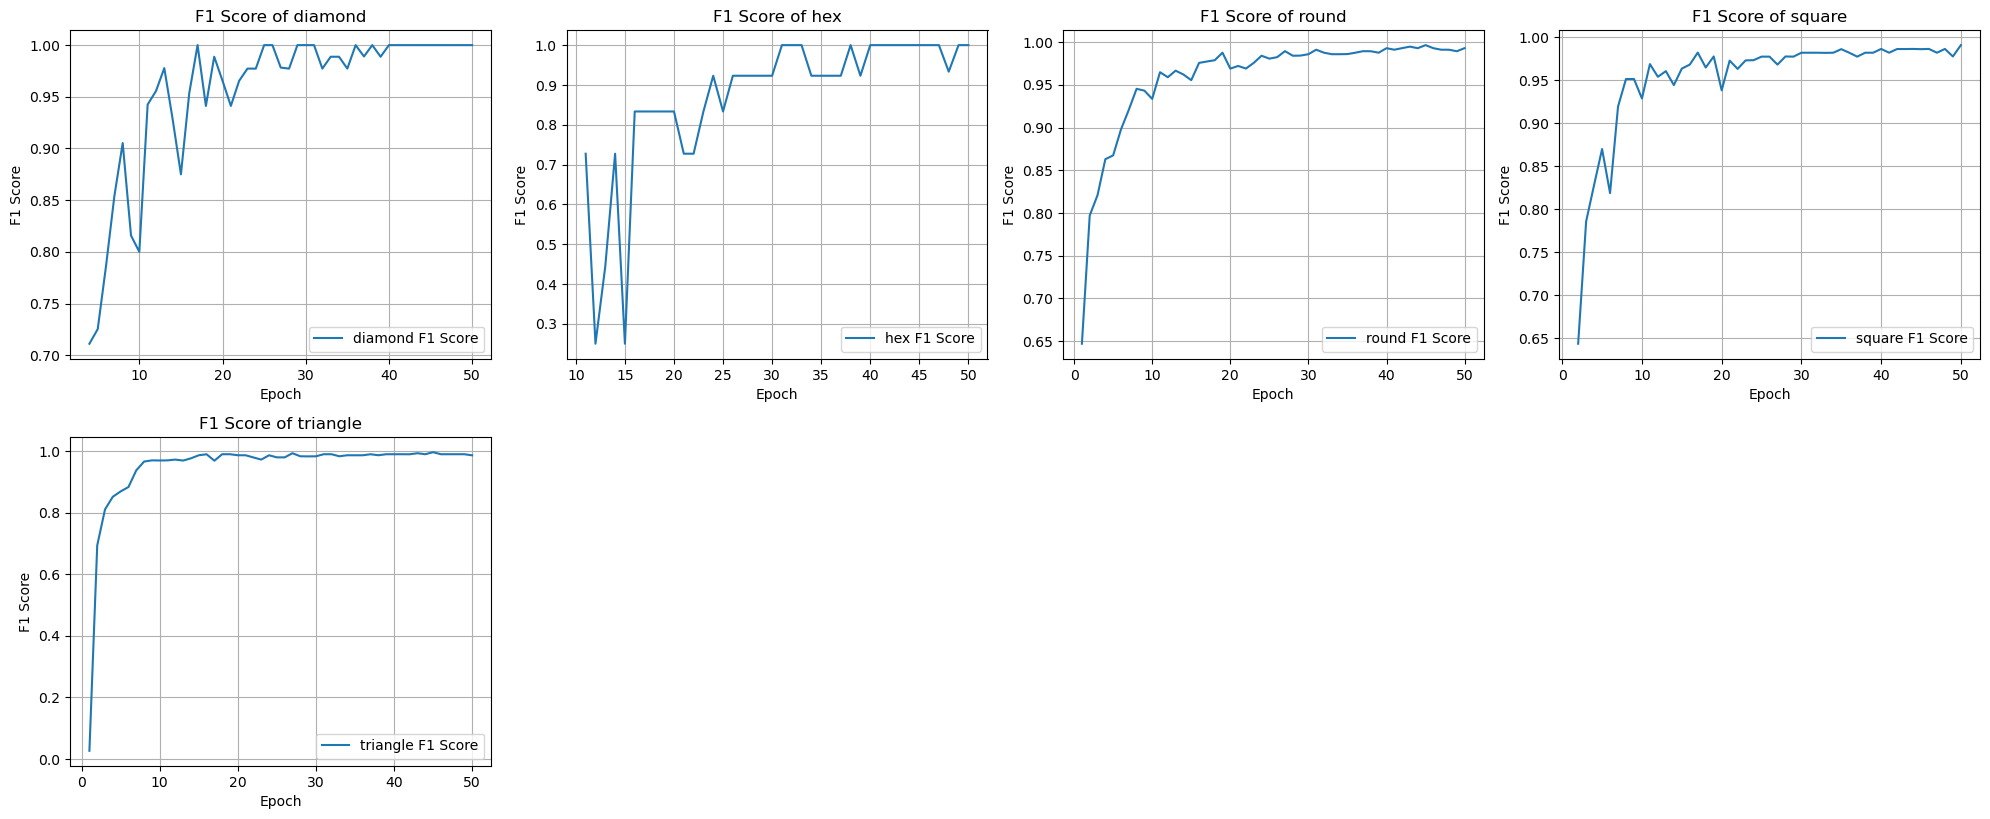

<Figure size 640x480 with 0 Axes>

In [55]:
import matplotlib.pyplot as plt

def plot_per_class_f1_scores(callback, label_names):
    """
    Plot the per-class F1 scores over the epochs in a 4x4 grid, each subplot representing one class.

    Parameters:
    - callback: Instance of PerClassF1Score that has been used during model training.
    - label_names: List of label names corresponding to each class.
    """
    epochs = len(callback.f1_scores_per_class)
    num_classes = len(label_names)
    f1_scores = np.array(callback.f1_scores_per_class)  # Shape will be [epochs, num_classes]

    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 16))
    axes = axes.flatten()

    for i in range(num_classes):
        ax = axes[i]
        ax.plot(range(1, epochs + 1), f1_scores[:, i], label=f'{label_names[i]} F1 Score')
        ax.set_title(f'F1 Score of {label_names[i]}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('F1 Score')
        ax.legend(loc='lower right')
        ax.grid(True)
        
    # Hide any unused subplots
    for i in range(num_classes, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

    plt.tight_layout()
    plt.show()
    


# Example of how to call this function
plot_per_class_f1_scores(per_class_f1_score_callback, label_names)
